# Centrality vector clustering visualisation

# Imports

In [1]:
import numpy as np 
import pandas as pd 
import networkx as nx
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import scipy as sp
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import to_rgba
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_hex
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors
from sklearn.metrics import silhouette_score, silhouette_samples

In [2]:
from module.utils import dendrogram_clustering, arr_from_arrstring, lighter_shades
from module.CenVec.vectorise import get_centrality_df
from module.graphpeeler import layer_realisation

In [3]:
cwd = Path.cwd()

In [ ]:
save_things=False
if save_things:
    fig_dir = cwd.parent / 'figures' 
    fig_dir.mkdir(parents=True, exist_ok=True)

# Karate club:


In [5]:
karate_g = nx.karate_club_graph()

slice_string = ['pre', 'post']
w_str = None
iw_str = None
karate_g.edges(data=True)

EdgeDataView([(0, 1, {'weight': 4}), (0, 2, {'weight': 5}), (0, 3, {'weight': 3}), (0, 4, {'weight': 3}), (0, 5, {'weight': 3}), (0, 6, {'weight': 3}), (0, 7, {'weight': 2}), (0, 8, {'weight': 2}), (0, 10, {'weight': 2}), (0, 11, {'weight': 3}), (0, 12, {'weight': 1}), (0, 13, {'weight': 3}), (0, 17, {'weight': 2}), (0, 19, {'weight': 2}), (0, 21, {'weight': 2}), (0, 31, {'weight': 2}), (1, 2, {'weight': 6}), (1, 3, {'weight': 3}), (1, 7, {'weight': 4}), (1, 13, {'weight': 5}), (1, 17, {'weight': 1}), (1, 19, {'weight': 2}), (1, 21, {'weight': 2}), (1, 30, {'weight': 2}), (2, 3, {'weight': 3}), (2, 7, {'weight': 4}), (2, 8, {'weight': 5}), (2, 9, {'weight': 1}), (2, 13, {'weight': 3}), (2, 27, {'weight': 2}), (2, 28, {'weight': 2}), (2, 32, {'weight': 2}), (3, 7, {'weight': 3}), (3, 12, {'weight': 3}), (3, 13, {'weight': 3}), (4, 6, {'weight': 2}), (4, 10, {'weight': 3}), (5, 6, {'weight': 5}), (5, 10, {'weight': 3}), (5, 16, {'weight': 3}), (6, 16, {'weight': 3}), (8, 30, {'weight': 3

In [6]:
# ccent = nx.closeness_centrality(karate_g, distance=None) 
deg_cent = nx.degree_centrality(karate_g)
# bcent = nx.betweenness_centrality(karate_g, weight=None)

cf_bcent = nx.current_flow_betweenness_centrality(karate_g, weight=None)
# ecent = nx.eigenvector_centrality(karate_g, weight=None)
# laplacian = nx.laplacian_centrality(karate_g, weight=w_str)
pagerank = nx.pagerank(karate_g)
harmonic = nx.harmonic_centrality(karate_g)
# katz = nx.katz_centrality(karate_g)
# katz_in = nx.katz_centrality(karate_g.)

# percolation = nx.percolation_centrality(karate_g)

centralities = {'cf_betweenness':cf_bcent,
                'degree':deg_cent, 
                'pagerank':pagerank, 
                'harmonic': harmonic}
c_df = pd.DataFrame(centralities)
c_df = pd.DataFrame(centralities)


In [7]:
# rescale these by ranking and taking the log of the ranking 
rank_karate_centralities =c_df.copy(True)

to_rank_cols = rank_karate_centralities.columns

for i in to_rank_cols:
    rank_karate_centralities[i] = np.log(rank_karate_centralities[i].rank(ascending=False, method='average'))


df_to_cluster = rank_karate_centralities
exclude = []  # exclude the ones that are not centralities
cents_for_clustering = set(df_to_cluster.columns) - set(exclude)

df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values
# specify_label_dict = id_to_ctype
method='ward'
metric='euclidean'
Z = linkage(df_to_cluster_cent, method=method, metric=metric) ####### linkage

cut = 0.3
t = max(Z[:,2]) * cut
clusteroutput = fcluster(Z, t=t, criterion='distance')
clusterlen = set(clusteroutput)
cmap = mpl.colormaps['tab10']

clustercmap = {int(val) : to_hex(cmap(ind)) for ind, val in enumerate(list(clusterlen))}
assignment = dict(zip(karate_g.nodes(), clusteroutput))
partition = [[node for node, val in assignment.items() if val==cl] for cl in list(clusterlen)]
leaf_to_color = {i:clustercmap.get(clusteroutput[ind]) for ind, i in enumerate(karate_g.nodes())}
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(Z) else to_hex(leaf_to_color[ind_to_id[x]])
        for x in i12)
    link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'black'


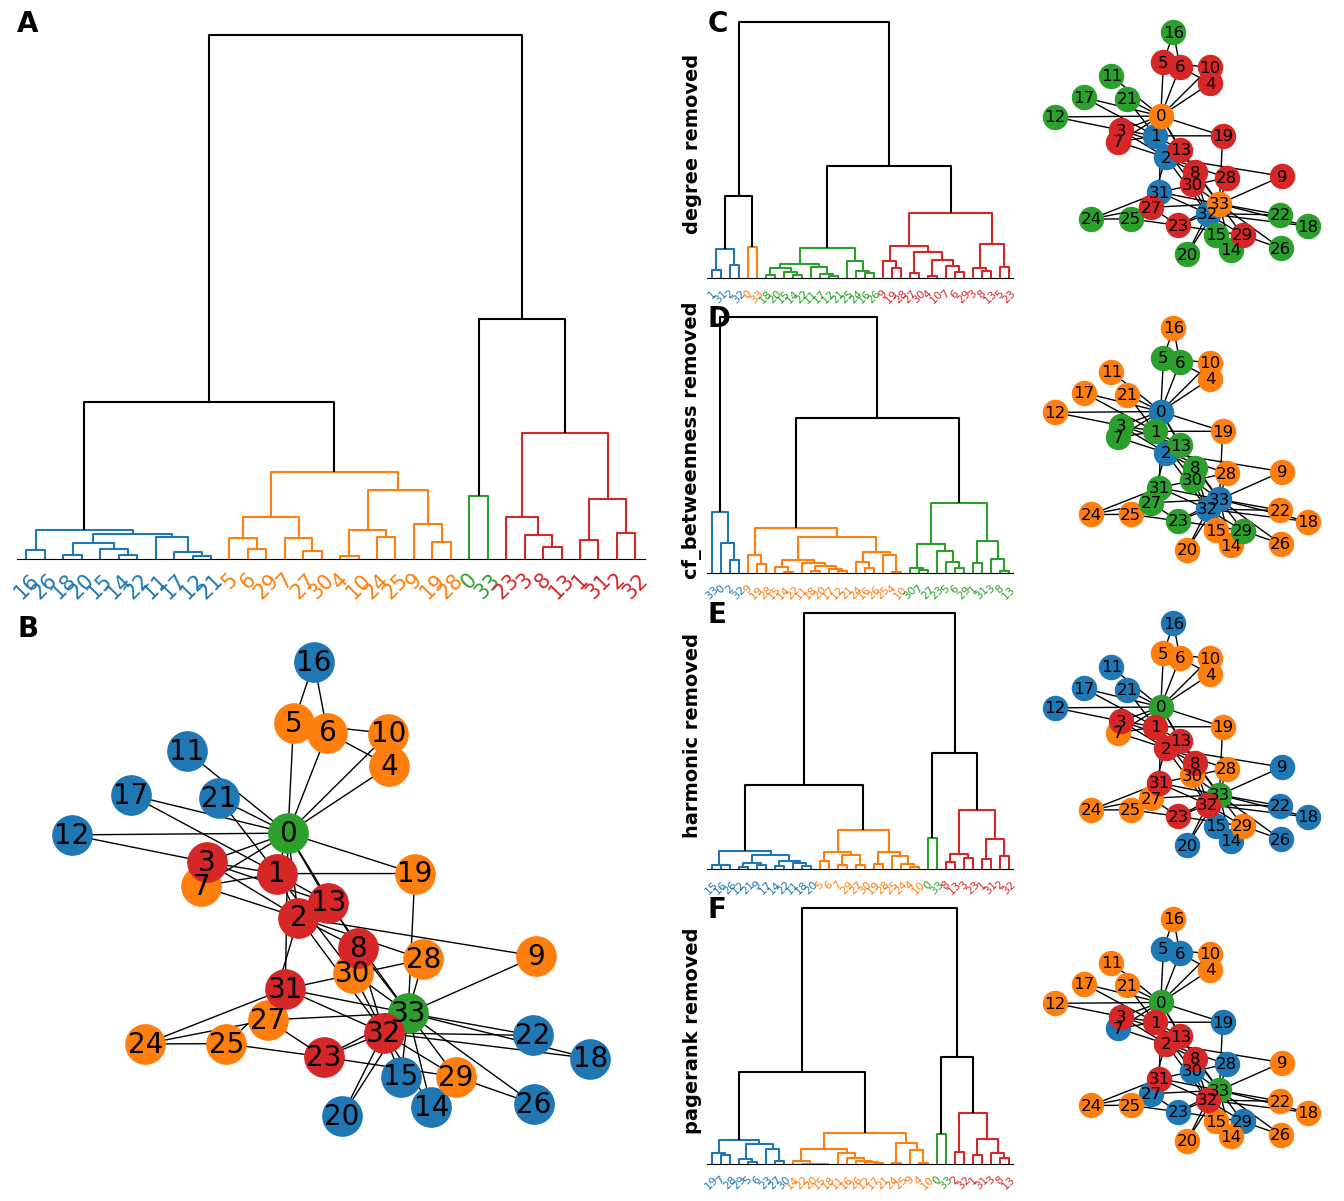

In [8]:
exclude = []  # exclude the ones that are not centralities

fig = plt.figure(figsize=(17, 15))
gs0 = GridSpec(1,2, figure=fig, width_ratios=[1,1], wspace=0.1)
gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0], height_ratios=[1,1], hspace=0.1)
gs2 = GridSpecFromSubplotSpec(4,2, subplot_spec=gs0[1], width_ratios=[1,1], wspace=0.05, height_ratios=[1 for _ in range(4)], hspace=0.1)

cmap = mpl.colormaps['tab10']

dend_ax = fig.add_subplot(gs1[0])
graph_ax = fig.add_subplot(gs1[1])
cents_for_clustering = set(df_to_cluster.columns)

df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values
# specify_label_dict = id_to_ctype
method='ward'
metric='euclidean'
Z = linkage(df_to_cluster_cent, method=method, metric=metric) ####### linkage
# title = f'Karate club centrality clustering, method={method}'
# dendrogram_clustering(Z=Z, labels=ind_to_id, clusters=[[None]], label_dict=False, title_str=f'{title}')
cut = 0.3
t = max(Z[:,2]) * cut
clusteroutput = fcluster(Z, t=t, criterion='distance')
clusterlen = set(clusteroutput)
assignment = dict(zip(karate_g.nodes(), clusteroutput))
partition = [[node for node, val in assignment.items() if val==cl] for cl in list(clusterlen)]
# plt.figure(figsize=(5,5))
pos = nx.spring_layout(karate_g, seed=0)
clustercmap = {int(val) : to_hex(cmap(ind)) for ind, val in enumerate(list(clusterlen))}
leaf_to_color = {i:clustercmap.get(clusteroutput[ind]) for ind, i in enumerate(karate_g.nodes())}
for ind, nodelist in enumerate(partition):
    nx.draw_networkx_nodes(karate_g, nodelist=nodelist, node_color=clustercmap.get(int(ind)+1), pos=pos, ax=graph_ax, node_size=800)
nx.draw_networkx_edges(karate_g, pos=pos, ax=graph_ax)
nx.draw_networkx_labels(karate_g, pos, ax=graph_ax, font_size=20)
graph_ax.axis('off')

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
    c1, c2 = (link_cols[x] if x > len(Z) else to_hex(leaf_to_color[ind_to_id[x]])
        for x in i12)
    link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'black'

col_dendrogram = dendrogram(Z, color_threshold=0, above_threshold_color='black', ax=dend_ax, labels=ind_to_id, link_color_func=lambda x: link_cols[x])
# ax_col_dendrogram.set_axis_off()
# dend_ax # make x axis labels larger
dend_ax.tick_params(axis='x', labelsize=15)
ylbls = dend_ax.get_xmajorticklabels()
for i in range(len(partition)):
    clstr = partition[i]
    # print(clstr)
    for lbl in ylbls:
        
        label_colors = {'True' : clustercmap[i+1], 'False' : 'black'}

        is_clstr = int(lbl.get_text()) in clstr
        # print(lbl.get_text())
        if is_clstr:
            lbl.set_color(label_colors[str(is_clstr)])

# dend_ax.set_xlabel
dend_ax.set_yticks([])
dend_ax.spines['left'].set_visible(False)
dend_ax.spines['top'].set_visible(False)
dend_ax.spines['right'].set_visible(False)
# dend_ax.set_ylabel(f'{term} removed', fontsize=14)
dend_ax.text(0, 1, 'A', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='top',  ha='left')
graph_ax.text(0, 1, 'B', transform=graph_ax.transAxes, fontsize=20, fontweight='bold', va='top',  ha='left')
# dend_ax.text(0, 1, 'B', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')

# dend_ax.text(0, 1, 'C', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')




subfig = 'CDEFGH'

for row_ind, term in enumerate(['degree', 'cf_betweenness', 'harmonic', 'pagerank']):
    dend_ax = fig.add_subplot(gs2[row_ind, 0])
    graph_ax = fig.add_subplot(gs2[row_ind, 1])
    # print(term)
    cents_for_clustering = set(df_to_cluster.columns) - set([term])

    df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
    ind_to_id = df_to_cluster_cent.index.values
    # specify_label_dict = id_to_ctype
    method='ward'
    metric='euclidean'
    Z = linkage(df_to_cluster_cent, method=method, metric=metric) ####### linkage
    title = f'Karate club centrality clustering, method={method}'
    # dendrogram_clustering(Z=Z, labels=ind_to_id, clusters=[[None]], label_dict=False, title_str=f'{title}')
    cut = 0.3
    t = max(Z[:,2]) * cut
    clusteroutput = fcluster(Z, t=t, criterion='distance')
    clusterlen = set(clusteroutput)
    assignment = dict(zip(karate_g.nodes(), clusteroutput))
    partition = [[node for node, val in assignment.items() if val==cl] for cl in list(clusterlen)]
    # plt.figure(figsize=(5,5))
    pos = nx.spring_layout(karate_g, seed=0)
    clustercmap = {int(val) : to_hex(cmap(ind)) for ind, val in enumerate(list(clusterlen))}
    leaf_to_color = {i:clustercmap.get(clusteroutput[ind]) for ind, i in enumerate(karate_g.nodes())}
    for ind, nodelist in enumerate(partition):
        nx.draw_networkx_nodes(karate_g, nodelist=nodelist, node_color=clustercmap.get(int(ind)+1), pos=pos, ax=graph_ax)
    nx.draw_networkx_edges(karate_g, pos=pos, ax=graph_ax)
    nx.draw_networkx_labels(karate_g, pos, ax=graph_ax)
    graph_ax.axis('off')

    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
        c1, c2 = (link_cols[x] if x > len(Z) else to_hex(leaf_to_color[ind_to_id[x]])
            for x in i12)
        link_cols[i+1+len(Z)] = c1 if c1 == c2 else 'black'

    col_dendrogram = dendrogram(Z, color_threshold=0, above_threshold_color='black', ax=dend_ax, labels=ind_to_id, link_color_func=lambda x: link_cols[x])
    # ax_col_dendrogram.set_axis_off()
    ylbls = dend_ax.get_xmajorticklabels()
    for i in range(len(partition)):
        clstr = partition[i]
        # print(clstr)
        for lbl in ylbls:
            
            label_colors = {'True' : clustercmap[i+1], 'False' : 'black'}

            is_clstr = int(lbl.get_text()) in clstr
            # print(lbl.get_text())
            if is_clstr:
                lbl.set_color(label_colors[str(is_clstr)])

    # dend_ax.set_xlabel
    dend_ax.set_yticks([])
    dend_ax.spines['left'].set_visible(False)
    dend_ax.spines['top'].set_visible(False)
    dend_ax.spines['right'].set_visible(False)
    dend_ax.set_ylabel(f'{term} removed', fontsize=14, fontweight='bold')
    dend_ax.text(0, 1, subfig[row_ind], transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='top',  ha='left')
    # dend_ax.text(0, 1, 'B', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')
    # dend_ax.text(0, 1, 'C', transform=dend_ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')

save_things = True
if save_things:
    plt.savefig(f'../figures/karate_clustering_abl.pdf', bbox_inches='tight', transparent=True)
    plt.savefig(f'../figures/karate_clustering_abl.png', bbox_inches='tight', transparent=True)
plt.show()



# Celegans

In [58]:
ce_meta = pd.read_csv('../../data/celegans/processed/ce_meta.csv', index_col=0)
ce_all_edges = pd.read_csv('../../data/celegans/processed/ce_all_edges.csv')
ce_chem_edges = pd.read_csv('../../data/celegans/processed/ce_chem_edges.csv')

In [59]:
ce_all_edges['attr'] = ce_all_edges.weight.apply(lambda x: {'weight':x, 'inv_weight':1/x})
alledge_centralities = get_centrality_df(edges=ce_all_edges, weighted=True)
# alledge_centralities.to_csv('../data/celegans/processed/alledge_centralities.csv')


# rescale these by ranking and taking the log of the ranking 
rank_alledge_centralities =alledge_centralities.copy(True)

to_rank_cols = alledge_centralities.columns

for i in to_rank_cols:
    rank_alledge_centralities[i] = np.log(rank_alledge_centralities[i].rank(ascending=False, method='average'))

# rank_alledge_centralities.to_csv('../data/celegans/processed/rank_alledge_centralities.csv')


In [60]:
rank_alledge_centralities

,in_harmonic,out_harmonic,in_pagerank,out_pagerank,degree,in_degree,out_degree,u_cf_bcent,strength,in_strength,out_strength
PVQR,5.147494,5.036953,4.976734,3.178054,3.761200,4.204693,3.828641,3.970292,4.356709,4.197202,4.634729
VB03,5.056246,5.429346,5.442418,5.411646,5.407172,5.347108,5.332719,5.572154,4.863681,5.491002,4.085976
ASEL,5.484797,3.663562,5.476464,4.663439,5.027165,5.049856,4.938065,4.882802,4.705016,5.159055,4.204693
FLPL,5.283204,1.098612,5.480639,2.708050,4.548600,4.875197,4.471639,5.117994,3.784190,5.233779,2.351375
SIBDR,5.351858,5.552960,4.727388,5.198497,5.517453,5.225747,5.598422,5.533389,5.634790,5.377591,5.643679
...,...,...,...,...,...,...,...,...,...,...,...
RIGR,4.382027,5.111988,4.343805,4.615121,3.384390,3.349904,3.998201,3.912023,4.094345,3.912023,4.762174
AS08,2.639057,4.795791,4.795791,5.598422,5.688669,5.654242,5.654242,5.698770,5.451038,4.890349,5.535364
PDEL,4.762174,3.091042,5.141664,3.401197,5.129899,5.049856,5.096813,5.293305,4.394449,4.658711,4.085976
RMDR,4.317488,5.214936,3.912023,5.398163,4.051785,3.349904,5.096813,4.382027,4.477337,3.970292,5.220356


In [61]:
df_to_cluster = rank_alledge_centralities


In [62]:
exclude = []
cents_for_clustering = set(df_to_cluster.columns) - set(exclude)

df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values


In [63]:
vector_df = df_to_cluster_cent

method='ward'
metric = 'euclidean'

dist_func = sp.spatial.distance.pdist 

ind_to_id = vector_df.index.values
Z = linkage(vector_df, method=method, metric=metric) ####### linkage


In [64]:
rel_meta_df = ce_meta.loc[ind_to_id]

In [65]:
fm_cs = ['#EE2617FF', '#0E54B6FF']


cs = ["#6497B1FF",  '#FFB04FFF','#6A359CFF', '#CD1076FF',  '#679C35FF',]
cs_2 = ['#F7FEAEFF', '#B7E6A5FF', '#7CCBA2FF', '#46AEA0FF', '#089099FF', '#00718BFF', '#045275FF']
cs_3 = ['#E84A00FF, #BB1D2CFF, #9B0C43FF, #661F66FF, #2C1F62FF, #006289FF, #004759FF, #003D3DFF, #002B2BFF'.split(', ')]

In [66]:
cmap = mpl.colormaps['tab10']

cclasses=['Pharynx', 'sensory neuron', 'motor neuron', 'interneuron']

cmap_ind = [9, 1, 2, 4]

classmap = dict(zip(cclasses, [cmap(i) for i in cmap_ind]))
cclass_list = [classmap[i] for i in sorted(cclasses)]

In [67]:
cat_to_plot = ['Final classification']
keep_cats = [None for _ in cat_to_plot] # None means keep all categories, otherwise specify a list of categories to keep
# cols = [fm_cs, cs_2] + [cs for _ in cat_to_plot[2:]]  # colors for each category, can be a list of colors or a single color for all categories
cols = [cclass_list]
# tf_ids = ud_vect_df.index.values # ordered transcription factor names (all)

plotobj = []

for cat, keep, c in zip(cat_to_plot, keep_cats, cols):
    rgba_colors = np.array([to_rgba(color) for color in c])
    unique_cats = sorted(rel_meta_df[cat].unique())
    print(unique_cats)
    if keep is None:
        keep = list(unique_cats)


    # arr, key = pd.factorize(list(rel_meta_df[cat]))

    arr, key = pd.factorize(keep + list(rel_meta_df[cat]))
    arr = arr[len(keep):]
    key = key[:len(keep)]
    
    # colors = cm.gnuplot(np.linspace(0,1,len(key)))
    colors = (rgba_colors[:len(key)])

    node_to_clusterid_arr = np.array([i if i < len(keep) else -1 for i in arr ]) # if not in enriched cluster, label as -1. 

    if -1 in node_to_clusterid_arr:
        colors = np.vstack([[1,1,1,1], colors])
    cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    plotobj.append((node_to_clusterid_arr, key, cluster_cmap))
    # cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    # plotobj.append((arr, key, cluster_cmap))


['Pharynx', 'interneuron', 'motor neuron', 'sensory neuron']


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_14876/542108730.py:19: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(keep + list(rel_meta_df[cat]))


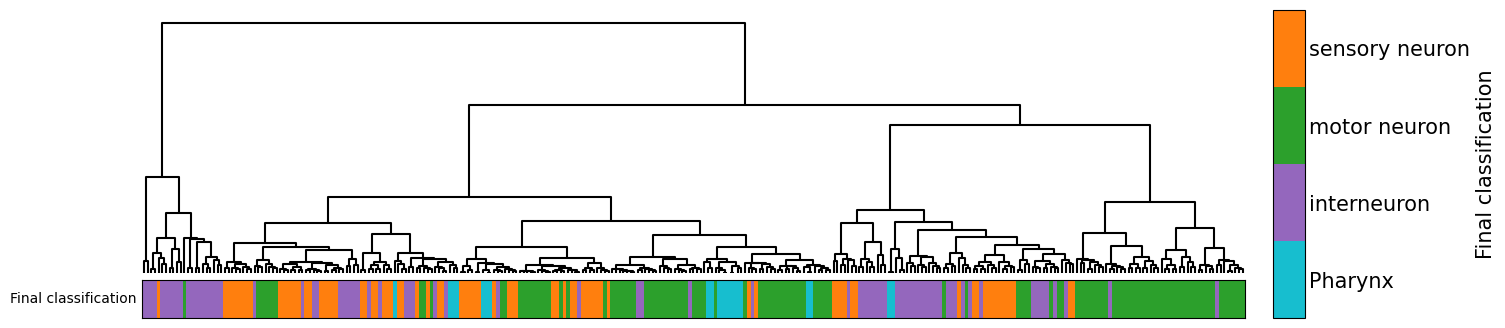

In [68]:
ncats = len(cat_to_plot) 
fig = plt.figure(figsize=(15, 3+ncats))
# fig.suptitle(f'{M} neighbours', fontsize=16)


gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)

gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
                                                  height_ratios=[7] + [1 for _ in range(ncats)],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(ncats,1, subplot_spec=gs0[1],
                                                  height_ratios=[1 for _ in range(ncats)],
                                                  hspace=0.05)




ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

for n in range(len(plotobj)):
    legend_ax = fig.add_subplot(gs2[n])

    arr, key, cluster_cmap = plotobj[n]

    if -1 in arr:
        key = ['other'] + list(key) # if we want white space for not represented 
    
    ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
    colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
    ax.set_yticks([])
    ax.set_ylabel(cat_to_plot[n], rotation=0, ha='right', va='center')
    ax.set_xticks([])
    # plt.setp(ax.get_xticklabels(), visible=False)
    # cclass.split('neuron')[0].strip(), xy=(-1, ind), verticalalignment="bottom",

    cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])
    yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

    cbar.set_label(cat_to_plot[n], size=15)  # Set label text and size
    cbar.set_ticks(ticks=yticks) # quirk with matplotlib
    legend_ax.tick_params(axis='y', labelsize=15)
    legend_ax.set_yticklabels(key, size=15)
    legend_ax.tick_params(length=0)




# # legend_ax = fig.add_subplot(gs2[-2])

# ax = fig.add_subplot(gs1[-2], sharex=ax_col_dendrogram)
# colrow = ax.imshow(ind_to_lr_balance[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
# ax.set_yticks([])
# ax.set_ylabel('L/R balance', rotation=0, ha='right', va='center')
# ax.set_xticks([])
# plt.setp(ax.get_xticklabels(), visible=False)

# # cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

# # cbar.set_label('L/R balance', size=12)  # Set label text and size
# # legend_ax.tick_params(axis='y', labelsize=12)


# legend_ax = fig.add_subplot(gs2[-1])

# ax = fig.add_subplot(gs1[-1], sharex=ax_col_dendrogram)
# colrow = ax.imshow(ind_to_prosocial[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
# ax.set_yticks([])
# ax.set_ylabel('prosocial', rotation=0, ha='right', va='center')
# ax.set_xticks([])
# plt.setp(ax.get_xticklabels(), visible=False)

# cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

# cbar.set_label('prosocial', size=12)  # Set label text and size
# legend_ax.tick_params(axis='y', labelsize=12)

if save_things:
    plt.savefig(fig_dir / 'celegans_c_clustering.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fig_dir / 'celegans_c_clustering.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [69]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Final classification'].values, metric='euclidean')

-0.01781146468632873

In [70]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Cook cell type'].values, metric='euclidean')

0.06138980583533988

In [71]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Cell Class'].values, metric='euclidean')

-0.043482358447117654

# Food web

In [23]:
fw_df = pd.read_csv('../../data/foodweb/fw_df.csv', index_col=0)
fw_meta_df = pd.read_csv('../../data/foodweb/fw_meta_df.csv', index_col=0)
fw_meta_fine_df = pd.read_csv('../../data/foodweb/fw_meta_fine_df.csv', index_col=0)
fw_meta_finest_df = pd.read_csv('../../data/foodweb/fw_meta_finest_df.csv', index_col=0)

In [24]:
fw_df.columns = ['pre', 'post']
fw_df['weight']=1
fw_df['attr'] = fw_df.weight.apply(lambda x: {'weight':x, 'inv_weight':1/x})
fw_centralities = get_centrality_df(edges=fw_df, weighted=False)
# chem_centralities.to_csv('../data/celegans/processed/chem_centralities.csv')

# rescale these by ranking and taking the log of the ranking 
rank_fw_centralities =fw_centralities.copy(True)

to_rank_cols = rank_fw_centralities.columns

for i in to_rank_cols:
    rank_fw_centralities[i] = np.log(rank_fw_centralities[i].rank(ascending=False, method='average'))

# rank_chem_centralities.to_csv('../data/celegans/processed/rank_chem_centralities.csv')


In [25]:
df_to_cluster = rank_fw_centralities

# cell_labelling = 'Cell Class'
# which_df = fw_meta_df.groupby('type')['node'].apply(list)
# which_df = fw_meta_fine_df.groupby('type')['node'].apply(list)
which_df = fw_meta_finest_df.groupby('type')['node'].apply(list)

In [26]:
exclude = []
cents_for_clustering = set(df_to_cluster.columns) - set(exclude)

df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values

vector_df = df_to_cluster_cent

method='ward'
metric = 'euclidean'

dist_func = sp.spatial.distance.pdist 

ind_to_id = vector_df.index.values
Z = linkage(vector_df, method=method, metric=metric) ####### linkage


In [27]:
meta_dict = fw_meta_df.set_index('node').type.to_dict()
types_unique = fw_meta_df.type.unique()
ind_to_meta = [meta_dict.get(i) for i in ind_to_id]

types_to_numeric =dict(zip(types_unique, [0,0,0,0,0,1,1,1,2,2,2,2,2,3,4,5,5,5,5])) # reassign the types to a numeric value
types_unique = set(types_to_numeric.values())

ind_to_numeric_meta = [types_to_numeric.get(meta) for meta in ind_to_meta]

numeric_to_types = {}
for t, numeric in types_to_numeric.items():
    l = numeric_to_types.get(numeric, list())
    l.append(t)
    numeric_to_types[numeric] = l

numeric_to_typestr = []
for numeric, tlist in numeric_to_types.items():
    numeric_to_typestr.append(', '.join(numeric_to_types[numeric]))

numeric_meta_dict = dict(zip(fw_meta_df.node, fw_meta_df.type.apply(types_to_numeric.get)))


In [28]:
colormap = plt.colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax=len(types_unique) - 1)
colors = [colormap(norm(i)) for i in range(len(types_unique))]
type_cmap = plt.matplotlib.colors.ListedColormap(colors)


In [29]:

prep_for_peeling = fw_df.iloc[:,:3].copy(True)
prep_for_peeling['weight'] = 1
prep_for_peeling.columns = ['pre', 'post', 'weight']

start_ids = list(set(prep_for_peeling.pre.unique()) - set(prep_for_peeling.post.unique()))

postId = prep_for_peeling['post'].values
preId = prep_for_peeling['pre'].values
in_strengths = prep_for_peeling.groupby('post').weight.sum().to_dict()
out_strengths = prep_for_peeling.groupby('pre').weight.sum().to_dict()

weights = prep_for_peeling['weight'].values

# weight of edges as a proportion of their strength:
prep_for_peeling['in_prop_weight'] = [weights[i]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))] 
prep_for_peeling['out_prop_weight'] = [weights[i]/out_strengths.get(preId[i]) for i in range(len(prep_for_peeling))]

# out-strength as a proportion of the total in and out strength:
out_strength_prop = {i : out_strengths.get(i, 0)/(in_strengths.get(i, 0) + out_strengths.get(i, 0)) for i in ind_to_id}

prep_for_peeling['in_div_out_prop_weight'] = [weights[i]*out_strength_prop[postId[i]]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))]

postId = prep_for_peeling['post'].values
preId = prep_for_peeling['pre'].values
in_strengths = prep_for_peeling.groupby('post').weight.sum().to_dict()
out_strengths = prep_for_peeling.groupby('pre').weight.sum().to_dict()

weights = prep_for_peeling['weight'].values

# weight of edges as a proportion of their strength:
prep_for_peeling['in_prop_weight'] = [weights[i]/in_strengths.get(postId[i]) for i in range(len(prep_for_peeling))] 
prep_for_peeling['out_prop_weight'] = [weights[i]/out_strengths.get(preId[i]) for i in range(len(prep_for_peeling))]

# out-strength as a proportion of the total in and out strength:
out_strength_prop = {i : out_strengths.get(i, 0)/(in_strengths.get(i, 0) + out_strengths.get(i, 0)) for i in ind_to_id}

In [30]:
N=1000
d_layers = []
for i in range(N): 
    nth_r = layer_realisation(df=prep_for_peeling,
                              start_ids=start_ids,
                              correction=1, 
                              N=np.inf, 
                              seed=i, 
                              prepost='pre', 
                              prop_weight='in_prop_weight')
    id_to_layer = {}
    for key, val in nth_r.items():
        for id in val:
            id_to_layer[id] = key
    d_layers.append(pd.Series(id_to_layer, name=f'r_{i}'))

d_layer_df = pd.concat(d_layers, axis=1)
d_colname = f'm_ds_layer'
d_layer_df[d_colname] = d_layer_df.mean(axis=1).sort_values()#.round(0).astype(int) # take the mean layer across all the runs
d_layer_df.index.names=['id']
d_layer_df = d_layer_df[[d_colname]]


layer_dict = d_layer_df[d_colname].round().astype(int).to_dict()


In [31]:

extra_fw_meta = pd.DataFrame({'layer': layer_dict, 'coarse_type': numeric_meta_dict})
rel_meta_df = extra_fw_meta.loc[ind_to_id]


In [32]:
# rel_meta_df.to_csv(cwd.parent.parent / 'data' / 'foodweb' / 'processed' / 'layer_coarse_meta.csv')

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4]


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_14876/2726610793.py:26: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(keep + list(rel_meta_df[cat]))


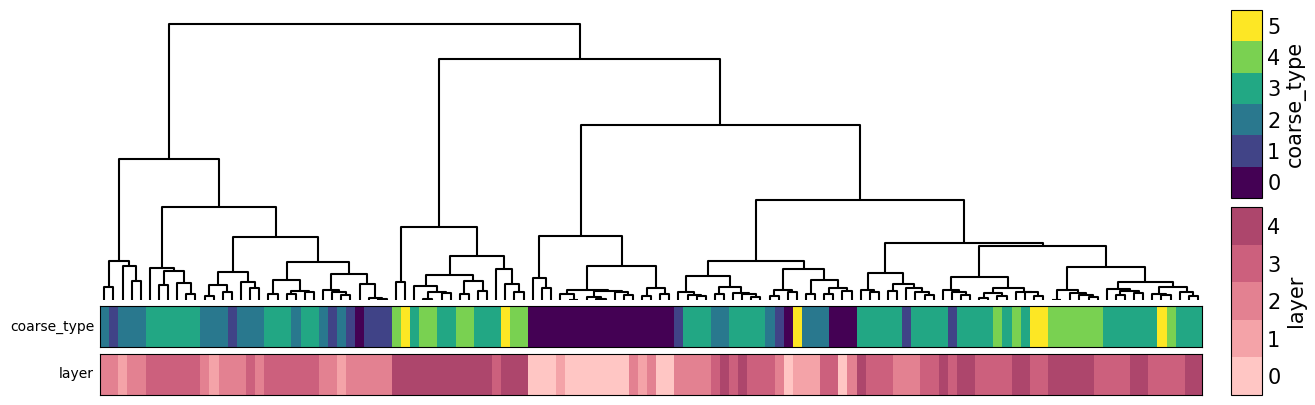

In [33]:
fm_cs = ['#EE2617FF', '#0E54B6FF']


cs = ["#6497B1FF",  '#FFB04FFF','#6A359CFF', '#CD1076FF',  '#679C35FF',]
cs_2 = ['#F7FEAEFF', '#B7E6A5FF', '#7CCBA2FF', '#46AEA0FF', '#089099FF', '#00718BFF', '#045275FF']
cs_3 = ['#E84A00FF, #BB1D2CFF, #9B0C43FF, #661F66FF, #2C1F62FF, #006289FF, #004759FF, #003D3DFF, #002B2BFF'.split(', ')]
cs_4 = ['#FFC6C4FF', '#F4A3A8FF', '#E38191FF', '#CC607DFF', '#AD466CFF', '#8B3058FF', '#672044FF']
cat_to_plot = ['coarse_type', 'layer']
keep_cats = [None for _ in cat_to_plot] # None means keep all categories, otherwise specify a list of categories to keep
# cols = [fm_cs, cs_2] + [cs for _ in cat_to_plot[2:]]  # colors for each category, can be a list of colors or a single color for all categories
cols = [type_cmap.colors, cs_4]
# tf_ids = ud_vect_df.index.values # ordered transcription factor names (all)

plotobj = []

for cat, keep, c in zip(cat_to_plot, keep_cats, cols):
    rgba_colors = np.array([to_rgba(color) for color in c])
    unique_cats = sorted(rel_meta_df[cat].unique())
    print(unique_cats)
    if keep is None:
        keep = list(unique_cats)


    # arr, key = pd.factorize(list(rel_meta_df[cat]))

    arr, key = pd.factorize(keep + list(rel_meta_df[cat]))
    arr = arr[len(keep):]
    key = key[:len(keep)]
    
    # colors = cm.gnuplot(np.linspace(0,1,len(key)))
    colors = (rgba_colors[:len(key)])

    node_to_clusterid_arr = np.array([i if i < len(keep) else -1 for i in arr ]) # if not in enriched cluster, label as -1. 

    if -1 in node_to_clusterid_arr:
        colors = np.vstack([[1,1,1,1], colors])
    cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    plotobj.append((node_to_clusterid_arr, key, cluster_cmap))
    # cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    # plotobj.append((arr, key, cluster_cmap))


ncats = len(cat_to_plot) 
fig = plt.figure(figsize=(15, 3+ncats))
# fig.suptitle(f'{M} neighbours', fontsize=16)


gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)

gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
                                                  height_ratios=[7] + [1 for _ in range(ncats)],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(ncats,1, subplot_spec=gs0[1],
                                                  height_ratios=[1 for _ in range(ncats)],
                                                  hspace=0.05)




ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

for n in range(len(plotobj)):
    legend_ax = fig.add_subplot(gs2[n])

    arr, key, cluster_cmap = plotobj[n]

    if -1 in arr:
        key = ['other'] + list(key) # if we want white space for not represented 
    
    ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
    colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
    ax.set_yticks([])
    ax.set_ylabel(cat_to_plot[n], rotation=0, ha='right', va='center')
    ax.set_xticks([])
    # plt.setp(ax.get_xticklabels(), visible=False)

    cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])
    yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

    cbar.set_label(cat_to_plot[n], size=15)  # Set label text and size
    cbar.set_ticks(ticks=yticks) # quirk with matplotlib
    legend_ax.tick_params(axis='y', labelsize=15)
    legend_ax.set_yticklabels(key, size=15)
    legend_ax.tick_params(length=0)




# # legend_ax = fig.add_subplot(gs2[-2])

# ax = fig.add_subplot(gs1[-2], sharex=ax_col_dendrogram)
# colrow = ax.imshow(ind_to_lr_balance[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
# ax.set_yticks([])
# ax.set_ylabel('L/R balance', rotation=0, ha='right', va='center')
# ax.set_xticks([])
# plt.setp(ax.get_xticklabels(), visible=False)

# # cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

# # cbar.set_label('L/R balance', size=12)  # Set label text and size
# # legend_ax.tick_params(axis='y', labelsize=12)


# legend_ax = fig.add_subplot(gs2[-1])

# ax = fig.add_subplot(gs1[-1], sharex=ax_col_dendrogram)
# colrow = ax.imshow(ind_to_prosocial[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
# ax.set_yticks([])
# ax.set_ylabel('prosocial', rotation=0, ha='right', va='center')
# ax.set_xticks([])
# plt.setp(ax.get_xticklabels(), visible=False)

# cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

# cbar.set_label('prosocial', size=12)  # Set label text and size
# legend_ax.tick_params(axis='y', labelsize=12)
# save_things=False
if save_things:
    plt.savefig(fig_dir / 'fw_c_clustering.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fig_dir / 'fw_c_clustering.png', dpi=300, bbox_inches='tight', transparent=True )
plt.show()

In [34]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'layer'].values, metric='euclidean')

0.07063326977519567

In [35]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'coarse_type'].values, metric='euclidean')

0.08227889828267522

# SHS 

In [104]:
s_hs_edges = pd.read_csv('../../data/s_hs_6/edges.csv')
s_hs_nodes = pd.read_csv('../../data/s_hs_6/nodes.csv')


s_hs_nodes.columns = [i[-1] for i in s_hs_nodes.columns.str.split()]
s_hs_nodes.index.name = 'node'
s_hs_nodes.index = s_hs_nodes.index.astype(str)

s_hs_edges.columns = [i[-1] for i in s_hs_edges.columns.str.split()]
# s_hs_edges = s_hs_edges.groupby(['source', 'target'], as_index=False)['count'].sum()
s_hs_edges.weight = s_hs_edges.weight.astype(int)


In [105]:
translation ={'Sexo':'Sex', 'crttotal':'CRT', 'Grupo':'Group', 'Curso':'Course'}

## pos & neg edges split

In [111]:
s_hs_edges_pos = s_hs_edges[s_hs_edges['weight'] >0].copy(True)
s_hs_edges_pos.weight = s_hs_edges_pos.weight.abs()
s_hs_edges_pos.columns = ['pre', 'post', 'weight']
s_hs_edges_pos['attr'] = s_hs_edges_pos.weight.apply(lambda x: {'weight':x, 'inv_weight':1/x})

s_hs_edges_neg = s_hs_edges[s_hs_edges['weight'] <0].copy(True)
s_hs_edges_neg.weight = s_hs_edges_neg.weight.abs()
s_hs_edges_neg.columns = ['pre', 'post', 'weight']
s_hs_edges_neg['attr'] = s_hs_edges_neg.weight.apply(lambda x: {'weight':x, 'inv_weight':1/x})

edges = [s_hs_edges_pos, s_hs_edges_neg]
# edges = [e[columnnames] for e in edges]
edge_centralities = []

for edge in edges:
    s_hs_centralities = get_centrality_df(edges=edge, weighted=True) #

    rank_s_hs_centralities = s_hs_centralities.copy(True)

    to_rank_cols = rank_s_hs_centralities.columns

    for i in to_rank_cols:
        rank_s_hs_centralities[i] = np.log(rank_s_hs_centralities[i].rank(ascending=False, method='average',))
    edge_centralities.append(rank_s_hs_centralities)
    # edge.index = edge.index.astype(str)

pn_rank_hs_centralities = edge_centralities[0].add_prefix('pos_').join(edge_centralities[1].add_prefix('neg_'))


In [112]:
df_to_cluster = pn_rank_hs_centralities #  rank_s_hs_centralities # 
df_to_cluster.index = df_to_cluster.index.astype(str)
which_df = s_hs_nodes.reset_index().groupby(['Sexo', 'prosocial', 'crttotal']).node.apply(list)

In [113]:
exclude = ['']
cents_for_clustering = set(df_to_cluster.columns) - set(exclude)


df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values

In [114]:
vector_df = df_to_cluster_cent.fillna(0)

method='ward'
metric = 'euclidean'

dist_func = sp.spatial.distance.pdist 

ind_to_id = vector_df.index.values
Z = linkage(vector_df, method=method, metric=metric) ####### linkage


In [115]:
rel_meta_df = s_hs_nodes.loc[ind_to_id]

In [116]:
fm_cs = ['#EE2617FF', '#0E54B6FF']
cs_2 = ['#F7FEAEFF', '#B7E6A5FF', '#7CCBA2FF', '#46AEA0FF', '#089099FF', '#00718BFF', '#045275FF']
cs = ["#6497B1FF",  '#FFB04FFF','#6A359CFF', '#CD1076FF',  '#679C35FF',]


In [117]:
cols_to_concat = ['Curso', 'Grupo']
rel_meta_df['grouped'] = rel_meta_df[cols_to_concat[0]].astype(str) + rel_meta_df[cols_to_concat[1]].astype(str)
curso_uniques = [str(i) for i in sorted(rel_meta_df['Curso'].unique())]
grupo_uniques = sorted(rel_meta_df['Grupo'].unique())
grouped_uniques = sorted(rel_meta_df['grouped'].unique())
n_shades = len(grupo_uniques)
fas_colours = np.hstack([lighter_shades(color, n_shades=n_shades-1) for color in cs])

In [118]:
cat_to_plot = ['Sexo', 'crttotal']
keep_cats = [None for _ in cat_to_plot] # None means keep all categories, otherwise specify a list of categories to keep
cols = [fm_cs, cs_2]# + [cs for _ in cat_to_plot[2:]]  # colors for each category, can be a list of colors or a single color for all categories
# tf_ids = ud_vect_df.index.values # ordered transcription factor names (all)

plotobj = []

for cat, keep, c in zip(cat_to_plot, keep_cats, cols):
    rgba_colors = np.array([to_rgba(color) for color in c])
    unique_cats = sorted(rel_meta_df[cat].unique())
    print(unique_cats)
    if keep is None:
        keep = list(unique_cats)
    arr, key = pd.factorize(keep + list(rel_meta_df[cat]))
    arr = arr[len(keep):]
    key = key[:len(keep)]
    
    colors = (rgba_colors[:len(key)])

    node_to_clusterid_arr = np.array([i if i < len(keep) else -1 for i in arr ]) # if not in enriched cluster, label as -1. 

    if -1 in node_to_clusterid_arr:
        colors = np.vstack([[1,1,1,1], colors])
    cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    plotobj.append((node_to_clusterid_arr, key, cluster_cmap))
    # cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    # plotobj.append((arr, key, cluster_cmap))

all_groups = [i+j for i in curso_uniques for j in grupo_uniques]
group_to_colour_dict = dict(zip(all_groups, fas_colours))
rgba_colors = np.array([to_rgba(group_to_colour_dict.get(i)) for i in grouped_uniques])
keep = grouped_uniques
arr, key = pd.factorize(grouped_uniques + list(rel_meta_df['grouped']))
arr = arr[len(keep):]
key = key[:len(keep)]
colors = (rgba_colors[:len(key)])
node_to_clusterid_arr = np.array([i if i < len(keep) else -1 for i in arr ]) # if not in enriched cluster, label as -1. 

cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
plotobj.append((node_to_clusterid_arr, curso_uniques, cluster_cmap))
cat_to_plot.append('Course')





['Female', 'Male']
[0, 1, 2, 3]


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_14876/2761424616.py:14: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(keep + list(rel_meta_df[cat]))
/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_14876/2761424616.py:33: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(grouped_uniques + list(rel_meta_df['grouped']))


In [119]:
base_color = "#727272"
color_list = lighter_shades(base_color, n_shades=4)


grupo_grey_cmap = mcolors.ListedColormap(color_list)
bounds = np.arange(len(grupo_uniques)+1) - 0.5 
norm = mcolors.BoundaryNorm(bounds, grupo_grey_cmap.N)


In [120]:
white_to_green = LinearSegmentedColormap.from_list("white_to_green", ["white", "green"])

ind_to_prosocial = rel_meta_df.prosocial.values
# ind_to_prosocial = rel_meta_df.prosocial.values


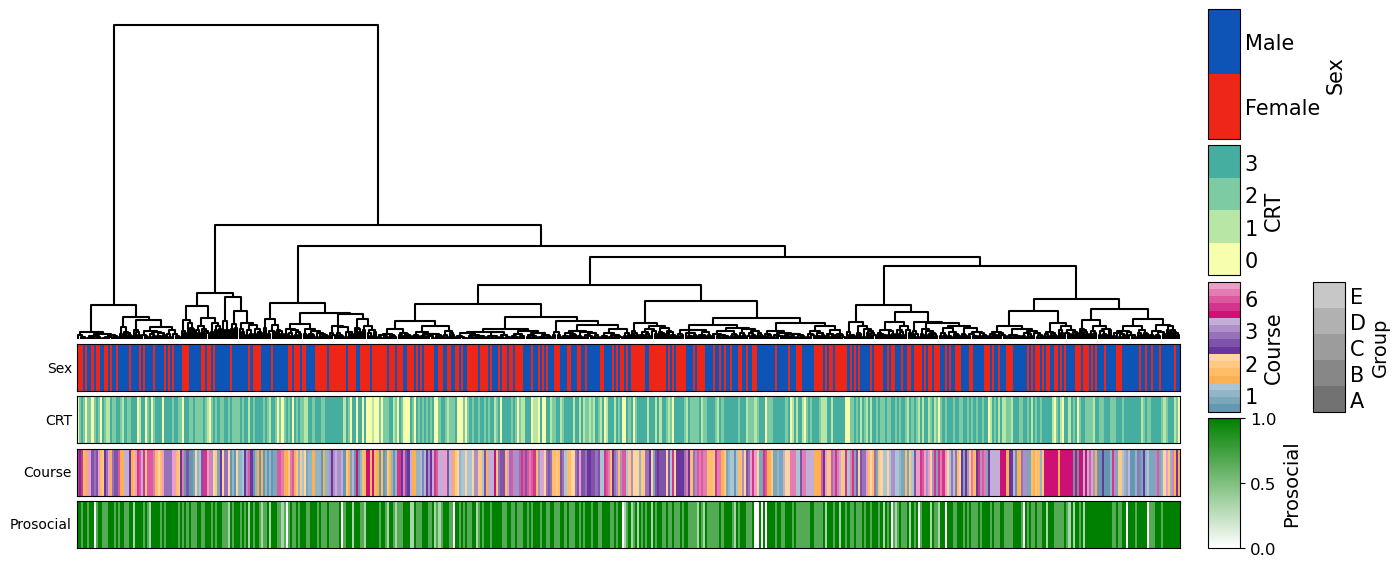

In [121]:
ncats = len(cat_to_plot) +1

fig = plt.figure(figsize=(15, 3+ncats))
# fig.suptitle(f'{M} neighbours', fontsize=16)


gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)

gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
                                                  height_ratios=[7] + [1 for _ in range(ncats)],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(ncats,1, subplot_spec=gs0[1],
                                                  height_ratios=[1 for _ in range(ncats)],
                                                  hspace=0.05)




ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')# link_color_func=lambda x: link_cols[x]
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

for n in range(len(plotobj)):
    legend_ax = fig.add_subplot(gs2[n])

    arr, key, cluster_cmap = plotobj[n]

    if -1 in arr:
        key = ['other'] + list(key) # if we want white space for not represented 
    
    ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
    colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
    ax.set_yticks([])
    ax.set_ylabel(translation.get(cat_to_plot[n], cat_to_plot[n]), rotation=0, ha='right', va='center')
    ax.set_xticks([])
    # plt.setp(ax.get_xticklabels(), visible=False)

    cbar = fig.colorbar(colrow, cax=legend_ax, label=translation.get(cat_to_plot[n], cat_to_plot[n]))
    yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

    cbar.set_label(translation.get(cat_to_plot[n], cat_to_plot[n]), size=15)  # Set label text and size
    cbar.set_ticks(ticks=yticks) # quirk with matplotlib
    legend_ax.tick_params(axis='y', labelsize=15)
    legend_ax.set_yticklabels(key, size=15)
    legend_ax.tick_params(length=0)



legend_ax = fig.add_subplot(gs2[-1])

ax = fig.add_subplot(gs1[-1], sharex=ax_col_dendrogram)
colrow = ax.imshow(ind_to_prosocial[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
ax.set_yticks([])
ax.set_ylabel('Prosocial', rotation=0, ha='right', va='center')
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), visible=False)

cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

cbar.set_label('Prosocial', size=14)  # Set label text and size
legend_ax.tick_params(axis='y', labelsize=12)


grupo_ax = fig.add_subplot(gs2[2])



sm = plt.cm.ScalarMappable(cmap=grupo_grey_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=grupo_ax)
# cbar.set_label('Cluster rank', size=15)
grupo_ax.set_yticks(np.arange(len(grupo_uniques)), labels=grupo_uniques)
# cbar.ax.set_yticklabels([str(i) for i in cluster_labels])  # or custom labels
cbar.ax.tick_params(labelsize=12)
grupo_ax.tick_params(which='minor', bottom=False, top=False, left=False, right=False)

pos = grupo_ax.get_position()

# Adjust values: (x0, y0, width, height)
new_pos = [pos.x0 + 0.07, pos.y0, pos.width, pos.height]
grupo_ax.set_position(new_pos)

# cbar = fig.colorbar(colrow, cax=grupo_ax, label=cat_to_plot[n])

cbar.set_label('Group', size=14)  # Set label text and size
# grupo_ax.tick_params(axis='y', labelsize=12)
# cbar.set_ticks(ticks=yticks) # quirk with matplotlib
grupo_ax.tick_params(axis='y', labelsize=15)
# legend_ax.set_yticklabels(key, size=15)

grupo_ax.tick_params(length=0)


if save_things:
    plt.savefig(fig_dir / 'shs_pn_c_clustering.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fig_dir / 'shs_pn_c_clustering.png', dpi=300, bbox_inches='tight', transparent=True)
    # plt.savefig(fig_dir / 'shs_c_clustering.pdf', dpi=300, bbox_inches='tight', transparent=True)
    # plt.savefig(fig_dir / 'shs_c_clustering.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()

In [122]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'crttotal'].values, metric='euclidean')

-0.08201260581834138

In [123]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Curso'].values, metric='euclidean')

-0.06170618070803641

In [ ]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Grupo'].values, metric='euclidean')

-0.07663885730309578

In [125]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Sexo'].values, metric='euclidean')

0.0036381653751926856

## Full figure

In [91]:
s_hs_edges.weight = s_hs_edges.weight.abs()
s_hs_edges.columns = ['pre', 'post', 'weight']

s_hs_edges['attr'] = s_hs_edges.weight.apply(lambda x: {'weight':x, 'inv_weight':1/x})


In [92]:
s_hs_centralities = get_centrality_df(edges=s_hs_edges, weighted=True) # 

rank_s_hs_centralities =s_hs_centralities.copy(True)

to_rank_cols = rank_s_hs_centralities.columns

for i in to_rank_cols:
    rank_s_hs_centralities[i] = np.log(rank_s_hs_centralities[i].rank(ascending=False, method='average'))

s_hs_nodes.index = s_hs_nodes.index.astype(str)

In [93]:
df_to_cluster = rank_s_hs_centralities # 

df_to_cluster.index = df_to_cluster.index.astype(str)
# df_to_cluster = rank_larva_centralities
which_df = s_hs_nodes.reset_index().groupby(['Sexo', 'prosocial', 'crttotal']).node.apply(list)

exclude = ['']
cents_for_clustering = set(df_to_cluster.columns) - set(exclude)


df_to_cluster_cent = df_to_cluster.loc[:, list(cents_for_clustering)]
ind_to_id = df_to_cluster_cent.index.values

vector_df = df_to_cluster_cent.fillna(0)

method='ward'
metric = 'euclidean'

dist_func = sp.spatial.distance.pdist 

ind_to_id = vector_df.index.values
Z = linkage(vector_df, method=method, metric=metric) ####### linkage


In [96]:
rel_meta_df

,index,name,Curso,Grupo,Sexo,prosocial,crttotal,_pos,grouped
node,,,,,,,,,
0,0,1091,6,A,Female,0.666667,1,"array([ 6.15773373, -1.35014201])",6A
1,1,1090,6,A,Female,1.000000,0,"array([ 6.19635888, -1.36021093])",6A
2,2,1093,6,A,Female,1.000000,2,"array([ 6.2125026 , -1.35847103])",6A
3,3,1095,6,A,Male,1.000000,0,"array([ 6.16715165, -1.30364885])",6A
4,4,1096,6,A,Male,1.000000,3,"array([ 6.2166382 , -1.31866247])",6A
...,...,...,...,...,...,...,...,...,...
529,529,1383,3,B,Male,0.666667,2,"array([ 6.1212159 , -1.07443658])",3B
530,530,1379,3,B,Female,0.666667,3,"array([ 6.01091988, -1.12404653])",3B
531,531,1400,3,B,Male,1.000000,0,"array([ 6.14652354, -1.06379729])",3B


In [97]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'crttotal'].values, metric='euclidean')

-0.06477183493143401

In [98]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Sexo'].values, metric='euclidean')

0.004936198772334299

In [99]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Grupo'].values, metric='euclidean')

-0.04091346098550299

In [100]:
silhouette_score(X=vector_df, labels=rel_meta_df.loc[ind_to_id,'Curso'].values, metric='euclidean')

-0.03456137896937101

In [52]:

t = max(Z[:,2]) * 0.3
clusteroutput = fcluster(Z, t=t, criterion='distance')
clusterlen = set(clusteroutput)
cmap = mpl.colormaps['tab10']
clustercmap = {val : cmap(ind) for ind, val in enumerate(list(clusterlen))}
assignment = dict(zip(rank_s_hs_centralities.index, clusteroutput))
partition = sorted([[int(node) for node, val in assignment.items() if val==cl] for cl in list(clusterlen)], key=lambda x:-len(x))

In [53]:
# curso_to_pos = s_hs_nodes.groupby('Curso')._pos.apply(list)
meta_copy = s_hs_nodes.copy(True)

meta_copy['_pos'] = meta_copy._pos.apply(func=arr_from_arrstring)
curso_to_pos = meta_copy.groupby('Curso')._pos.apply(np.array)
rel_meta_df = s_hs_nodes.loc[ind_to_id]

In [54]:
node_to_color = {key: to_hex(clustercmap[val]) for key, val in assignment.items()}
fm_cs = ['#EE2617FF', '#0E54B6FF']
cs = ["#6497B1FF",  '#FFB04FFF','#6A359CFF', '#CD1076FF',  '#679C35FF',]
cs_2 = ['#F7FEAEFF', '#B7E6A5FF', '#7CCBA2FF', '#46AEA0FF', '#089099FF', '#00718BFF', '#045275FF']
cs_3 = ['#E84A00FF, #BB1D2CFF, #9B0C43FF, #661F66FF, #2C1F62FF, #006289FF, #004759FF, #003D3DFF, #002B2BFF'.split(', ')]

In [55]:
cols_to_concat = ['Curso', 'Grupo']
rel_meta_df['grouped'] = rel_meta_df[cols_to_concat[0]].astype(str) + rel_meta_df[cols_to_concat[1]].astype(str)
curso_uniques = [str(i) for i in sorted(rel_meta_df['Curso'].unique())]
grupo_uniques = sorted(rel_meta_df['Grupo'].unique())
grouped_uniques = sorted(rel_meta_df['grouped'].unique())
n_shades = len(grupo_uniques)
fas_colours = np.hstack([lighter_shades(color, n_shades=n_shades-1) for color in cs])
cat_to_plot = ['Sexo', 'crttotal']
keep_cats = [None for _ in cat_to_plot] # None means keep all categories, otherwise specify a list of categories to keep
cols = [fm_cs, cs_2]# + [cs for _ in cat_to_plot[2:]]  # colors for each category, can be a list of colors or a single color for all categories
# tf_ids = ud_vect_df.index.values # ordered transcription factor names (all)

plotobj = []

for cat, keep, c in zip(cat_to_plot, keep_cats, cols):
    rgba_colors = np.array([to_rgba(color) for color in c])
    unique_cats = sorted(rel_meta_df[cat].unique())
    print(unique_cats)
    if keep is None:
        keep = list(unique_cats)
    arr, key = pd.factorize(keep + list(rel_meta_df[cat]))
    arr = arr[len(keep):]
    key = key[:len(keep)]
    
    colors = (rgba_colors[:len(key)])

    node_to_clusterid_arr = np.array([i if i < len(keep) else -1 for i in arr ]) # if not in enriched cluster, label as -1. 

    if -1 in node_to_clusterid_arr:
        colors = np.vstack([[1,1,1,1], colors])
    cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    plotobj.append((node_to_clusterid_arr, key, cluster_cmap))
    # cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
    # plotobj.append((arr, key, cluster_cmap))

all_groups = [i+j for i in curso_uniques for j in grupo_uniques]
group_to_colour_dict = dict(zip(all_groups, fas_colours))
rgba_colors = np.array([to_rgba(group_to_colour_dict.get(i)) for i in grouped_uniques])
keep = grouped_uniques
arr, key = pd.factorize(grouped_uniques + list(rel_meta_df['grouped']))
arr = arr[len(keep):]
key = key[:len(keep)]
colors = (rgba_colors[:len(key)])
node_to_clusterid_arr = np.array([i if i < len(keep) else -1 for i in arr ]) # if not in enriched cluster, label as -1. 

cluster_cmap = plt.matplotlib.colors.ListedColormap(colors)
plotobj.append((node_to_clusterid_arr, curso_uniques, cluster_cmap))
cat_to_plot.append('Course')





['Female', 'Male']
[0, 1, 2, 3]


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_14876/1339289053.py:21: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(keep + list(rel_meta_df[cat]))
/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_14876/1339289053.py:40: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  arr, key = pd.factorize(grouped_uniques + list(rel_meta_df['grouped']))


In [56]:
dflt_col = "black"   # Unclustered black
link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else node_to_color[ind_to_id[x]]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col


/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


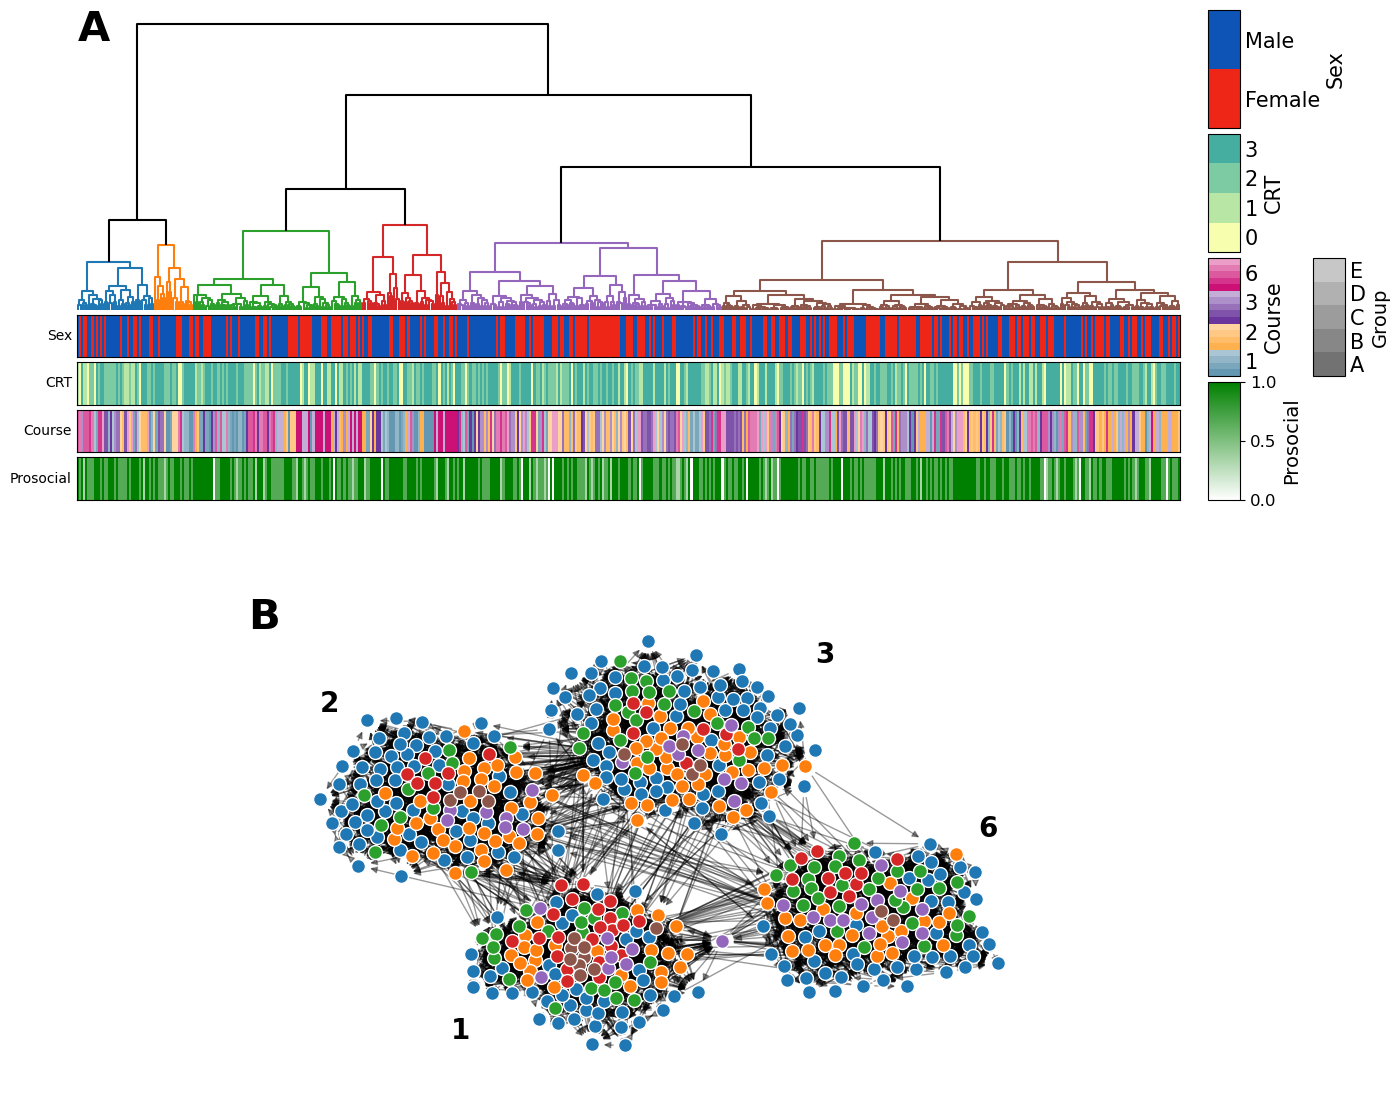

In [57]:
ncats = len(cat_to_plot) +1
# fig = plt.figure(figsize=(15, 3+ncats))
fig = plt.figure(figsize=(15, 2*(3+ncats)))

# fig.suptitle(f'{M} neighbours', fontsize=16)

gs = GridSpec(2,1, figure=fig, height_ratios=[1,1])
# gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)
gs0 = GridSpecFromSubplotSpec(1,2, subplot_spec=gs[0],
                                                  width_ratios=[35,1],
                                                  wspace=0.05)


gs1 = GridSpecFromSubplotSpec(1+ncats,1, subplot_spec=gs0[0],
                                                  height_ratios=[7] + [1 for _ in range(ncats)],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(ncats,1, subplot_spec=gs0[1],
                                                  height_ratios=[1 for _ in range(ncats)],
                                                  hspace=0.05)

gs3 = GridSpecFromSubplotSpec(1,3, subplot_spec=gs[1],
                                                  width_ratios=[1, 8, 1])

graph_ax = fig.add_subplot(gs3[1])




ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black', link_color_func=lambda x: link_cols[x])
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

for n in range(len(plotobj)):
    legend_ax = fig.add_subplot(gs2[n])

    arr, key, cluster_cmap = plotobj[n]

    if -1 in arr:
        key = ['other'] + list(key) # if we want white space for not represented 
    
    ax = fig.add_subplot(gs1[1+n], sharex=ax_col_dendrogram)
    colrow = ax.imshow(arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
    ax.set_yticks([])
    ax.set_ylabel(translation.get(cat_to_plot[n], cat_to_plot[n]), rotation=0, ha='right', va='center')
    ax.set_xticks([])
    # plt.setp(ax.get_xticklabels(), visible=False)

    cbar = fig.colorbar(colrow, cax=legend_ax, label=translation.get(cat_to_plot[n], cat_to_plot[n]))
    yticks = np.linspace(*legend_ax.get_ylim(), len(key)+1)[:-1] + ((legend_ax.get_ylim()[1]-legend_ax.get_ylim()[0]) / len(key) / 2)

    cbar.set_label(translation.get(cat_to_plot[n], cat_to_plot[n]), size=15)  # Set label text and size
    cbar.set_ticks(ticks=yticks) # quirk with matplotlib
    legend_ax.tick_params(axis='y', labelsize=15)
    legend_ax.set_yticklabels(key, size=15)
    legend_ax.tick_params(length=0)



legend_ax = fig.add_subplot(gs2[-1])

ax = fig.add_subplot(gs1[-1], sharex=ax_col_dendrogram)
colrow = ax.imshow(ind_to_prosocial[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=white_to_green, interpolation='nearest')
ax.set_yticks([])
ax.set_ylabel('Prosocial', rotation=0, ha='right', va='center')
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), visible=False)

cbar = fig.colorbar(colrow, cax=legend_ax, label=cat_to_plot[n])

cbar.set_label('Prosocial', size=14)  # Set label text and size
legend_ax.tick_params(axis='y', labelsize=12)


grupo_ax = fig.add_subplot(gs2[2])



sm = plt.cm.ScalarMappable(cmap=grupo_grey_cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=grupo_ax)
# cbar.set_label('Cluster rank', size=15)
grupo_ax.set_yticks(np.arange(len(grupo_uniques)), labels=grupo_uniques)
# cbar.ax.set_yticklabels([str(i) for i in cluster_labels])  # or custom labels
cbar.ax.tick_params(labelsize=12)
grupo_ax.tick_params(which='minor', bottom=False, top=False, left=False, right=False)

pos = grupo_ax.get_position()

# Adjust values: (x0, y0, width, height)
new_pos = [pos.x0 + 0.07, pos.y0, pos.width, pos.height]
grupo_ax.set_position(new_pos)

# cbar = fig.colorbar(colrow, cax=grupo_ax, label=cat_to_plot[n])

cbar.set_label('Group', size=14)  # Set label text and size
# grupo_ax.tick_params(axis='y', labelsize=12)
# cbar.set_ticks(ticks=yticks) # quirk with matplotlib
grupo_ax.tick_params(axis='y', labelsize=15)
# legend_ax.set_yticklabels(key, size=15)

grupo_ax.tick_params(length=0)



s_hs_g = nx.DiGraph()
s_hs_g.add_edges_from(s_hs_edges[['pre', 'post', 'attr']].to_numpy())

# pos = nx.spring_layout(s_hs_g, seed=0)
pos = s_hs_nodes._pos.apply(func=arr_from_arrstring).to_dict()
pos = {int(key): value for key, value in pos.items()}

for ind, nodelist in enumerate(partition):
    nx.draw_networkx_nodes(s_hs_g, nodelist=nodelist, node_color=clustercmap.get(ind+1), pos=pos, edgecolors='white', node_size=100, ax=graph_ax)
nx.draw_networkx_edges(s_hs_g, pos=pos, alpha=0.4, ax=graph_ax)
# nx.draw_networkx_labels(s_hs_g, pos)
graph_ax.axis('off')
# plt.show()
for ind, curso in enumerate(sorted(meta_copy.Curso.unique())):
    coords = np.stack(curso_to_pos[curso])
    
    if curso == 2 :
        x_coord = np.min(coords[:, 0])
        y_coord = np.max(coords[:, 1])
        ha='left'
        va='bottom'
    if curso == 1 :
        x_coord = np.min(coords[:, 0])
        y_coord = np.min(coords[:, 1])
        ha='right'
        va='bottom'
    if curso == 6 :
        x_coord = np.max(coords[:, 0])
        y_coord = np.max(coords[:, 1])
        ha='right'
        va='bottom'
    if curso == 3 :
        x_coord = np.max(coords[:, 0])
        y_coord = np.max(coords[:, 1])
        ha='left'
        va='top'

    graph_ax.text(x_coord, y_coord, s=f'{curso}', va=va, ha=ha, fontweight='bold', fontsize=20,)

graph_ax.text(0, 1, 'B', transform=graph_ax.transAxes, fontsize=30, fontweight='bold', va='top',  ha='left')
ax_col_dendrogram.text(0, 1, 'A', transform=ax_col_dendrogram.transAxes, fontsize=30, fontweight='bold', va='top',  ha='left')



# save_things=True
if save_things:
    plt.savefig(fig_dir / 'shs_c_clustering_full.pdf', dpi=300, bbox_inches='tight', transparent=True)
    plt.savefig(fig_dir / 'shs_c_clustering_full.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()